# 04 - DBSCAN

## Introdução

O **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clustering baseado em densidade desenvolvido por Martin Ester e colaboradores em 1996. Diferentemente do K-Means e clustering hierárquico, o DBSCAN não requer que especifiquemos o número de clusters antecipadamente e é capaz de identificar clusters de formas arbitrárias e detectar outliers (ruído).

### Características Principais do DBSCAN:

1. **Baseado em densidade**: Agrupa pontos que estão densamente empacotados
2. **Detecção de ruído**: Identifica automaticamente outliers
3. **Forma arbitrária**: Pode encontrar clusters de qualquer formato
4. **Número automático de clusters**: Não precisa especificar k antecipadamente
5. **Robusto a outliers**: Outliers não afetam a formação dos clusters

## Fundamentos Matemáticos

O DBSCAN utiliza dois parâmetros principais:
- $\varepsilon$ (eps): raio da vizinhança
- $\text{minPts}$: número mínimo de pontos para formar um cluster

### Definições Fundamentais:

**1. Vizinhança-$\varepsilon$**: Para um ponto $p$, sua vizinhança-$\varepsilon$ é definida como:
$$N_\varepsilon(p) = \{q \in D | \text{dist}(p,q) \leq \varepsilon\}$$

**2. Ponto Central (Core Point)**: Um ponto $p$ é um ponto central se:
$$|N_\varepsilon(p)| \geq \text{minPts}$$

**3. Diretamente Alcançável por Densidade**: Um ponto $q$ é diretamente alcançável por densidade a partir de $p$ se:
- $q \in N_\varepsilon(p)$ e
- $p$ é um ponto central

**4. Alcançável por Densidade**: Um ponto $q$ é alcançável por densidade a partir de $p$ se existe uma cadeia de pontos $p_1, p_2, ..., p_n$ onde $p_1 = p$ e $p_n = q$, tal que $p_{i+1}$ é diretamente alcançável por densidade a partir de $p_i$.

**5. Conectado por Densidade**: Dois pontos $p$ e $q$ são conectados por densidade se existe um ponto $o$ tal que tanto $p$ quanto $q$ são alcançáveis por densidade a partir de $o$.

### Classificação dos Pontos:

- **Core Point (Ponto Central)**: $|N_\varepsilon(p)| \geq \text{minPts}$
- **Border Point (Ponto de Fronteira)**: $|N_\varepsilon(p)| < \text{minPts}$, mas está na vizinhança de um core point
- **Noise Point (Ponto de Ruído)**: Não é core nem border point

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(1)

## Implementação do DBSCAN

Vamos implementar o algoritmo DBSCAN passo a passo usando apenas NumPy:

In [36]:
!pip install dtaidistance
from dtaidistance import dtw

class DBSCAN:
    def __init__(self, eps=0.5, min_pts=5, metric='euclidean'):
        """Inicializa o DBSCAN com os parâmetros eps e min_pts"""
        self.eps = eps
        self.min_pts = min_pts
        self.metric = metric
        self.labels_ = None
        self.core_samples_ = None
        self.n_clusters_ = 0

    def _calculate_distance_matrix(self, X):
        """Calcula a matriz de distâncias entre todos os pontos"""
        n_points = len(X)
        distances = np.zeros((n_points, n_points))

        if self.metric == 'euclidean':
            distances = np.linalg.norm(X[:, np.newaxis] - X, axis=2)
        elif self.metric == 'radial':
            distances_to_origin = np.linalg.norm(X, axis=1)
            distances = np.abs(distances_to_origin[:, np.newaxis] - distances_to_origin)
        elif self.metric == 'dtw':
            for i in range(n_points):
                for j in range(i + 1, n_points):
                    dist = dtw.distance_fast(X[i], X[j])
                    distances[i, j] = distances[j, i] = dist
        else:
            raise ValueError("Métrica não suportada")
        return distances

    def _get_neighbors(self, point_idx, distance_matrix):
        """Encontra todos os vizinhos dentro da distância eps"""
        # This function now works with any distance matrix calculated by _calculate_distance_matrix
        return np.where(distance_matrix[point_idx] <= self.eps)[0]


    def _expand_cluster(self, point_idx, neighbors, cluster_id, distance_matrix, visited, labels):
        """Expande o cluster a partir do ponto inicial"""
        labels[point_idx] = cluster_id
        queue = neighbors.tolist()

        while queue:
            neighbor_idx = queue.pop()

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._get_neighbors(neighbor_idx, distance_matrix)

                # Check if the neighbor is a core point
                if len(neighbor_neighbors) >= self.min_pts:
                    queue.extend(neighbor_neighbors)

            # Assign the current cluster_id if the point is not already classified as noise (-1)
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id


    def fit(self, X):
        """Executa o algoritmo DBSCAN"""
        n_points = len(X)
        visited = np.zeros(n_points, dtype=bool)
        cluster_id = 0
        self.labels_ = np.full(n_points, -1)  # -1 = ruído
        self.core_samples_ = []

        # Calculate the distance matrix using the specified metric
        distance_matrix = self._calculate_distance_matrix(X)

        for point_idx in range(n_points):
            if visited[point_idx]:
                continue

            visited[point_idx] = True
            neighbors = self._get_neighbors(point_idx, distance_matrix)

            if len(neighbors) >= self.min_pts:   # core point
                self.core_samples_.append(point_idx)
                # Expand the cluster from this core point
                self._expand_cluster(point_idx, neighbors, cluster_id, distance_matrix, visited, self.labels_)
                cluster_id += 1

        self.core_samples_ = np.array(self.core_samples_)
        self.n_clusters_ = cluster_id
        return self

    def fit_predict(self, X):
        """Executa DBSCAN e retorna os labels"""
        self.fit(X)
        return self.labels_

## Demonstração com Dados Sintéticos

Vamos criar dados sintéticos para demonstrar o funcionamento do DBSCAN:

In [37]:
rng = np.random.default_rng(42)

# Cabeça: círculo com leve ruído
n_head = 400
theta = rng.uniform(0, 2*np.pi, n_head)
R = 10 + rng.normal(0, 0.35, n_head)
head = np.c_[R*np.cos(theta), R*np.sin(theta)]
y_head = np.full(n_head, 0)

# Olhos: dois blobs gaussianos
n_eye = 100
eye_left  = rng.normal(loc=[-3.2,  3.0], scale=[0.45, 0.45], size=(n_eye//2, 2))
eye_right = rng.normal(loc=[ 3.2,  3.0], scale=[0.45, 0.45], size=(n_eye - n_eye//2, 2))
eyes = np.vstack([eye_left, eye_right])
y_eyes = np.full(eyes.shape[0], 1)

# Boca: arco inferior com jitter (sorriso)
n_mouth = 100
phi = rng.uniform(np.deg2rad(200), np.deg2rad(340), n_mouth)  # arco de 200° a 340°
Rm = 5 + rng.normal(0, 0.22, n_mouth)
mouth = np.c_[Rm*np.cos(phi), -1 + Rm*np.sin(phi)]
mouth += rng.normal(0, [0.12, 0.15], mouth.shape)  # engrossar um pouco
y_mouth = np.full(n_mouth, 2)

# Ruído: pontos aleatórios
n_noise = 100
noise = rng.uniform(low=[-13, -13], high=[13, 13], size=(n_noise, 2))
y_noise = np.full(n_noise, -1)

# Concatenar
X_synthetic = np.vstack([head, eyes, mouth, noise])
true_labels  = np.concatenate([y_head, y_eyes, y_mouth, y_noise])

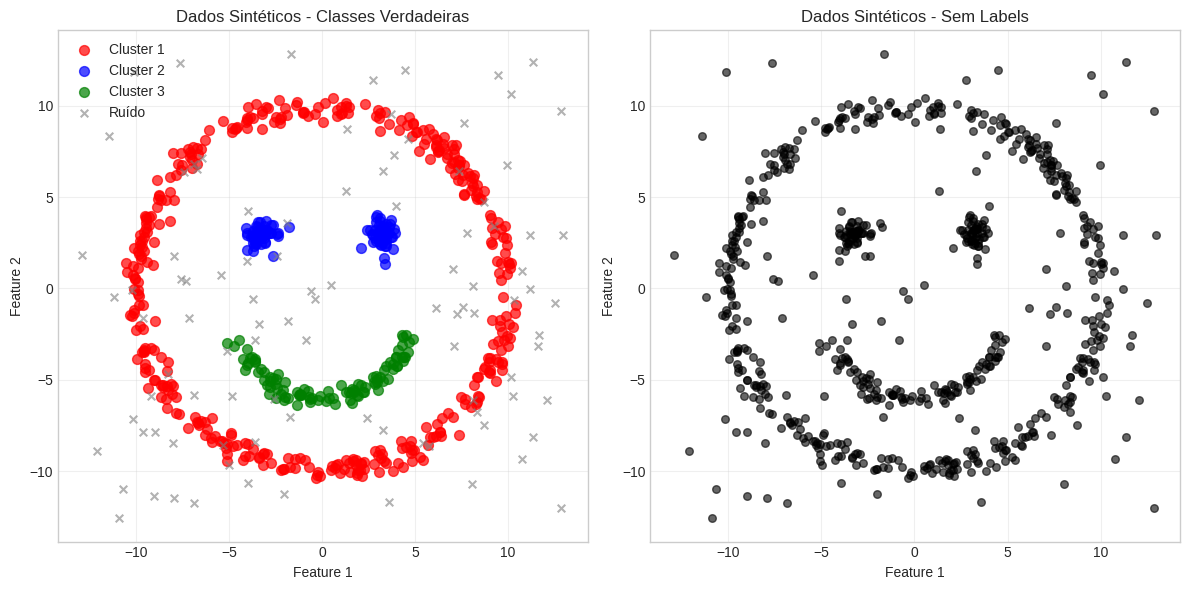

In [38]:
# Visualizar os dados sintéticos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'gray']
for i in range(4):
    if i == 3:  # ruído
        mask = true_labels == -1
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=colors[i], alpha=0.6, s=30, marker='x', label='Ruído')
    else:
        mask = true_labels == i
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=colors[i], alpha=0.7, s=50, label=f'Cluster {i+1}')

plt.title('Dados Sintéticos - Classes Verdadeiras')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_synthetic[:, 0], X_synthetic[:, 1], c='black', alpha=0.6, s=30)
plt.title('Dados Sintéticos - Sem Labels')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

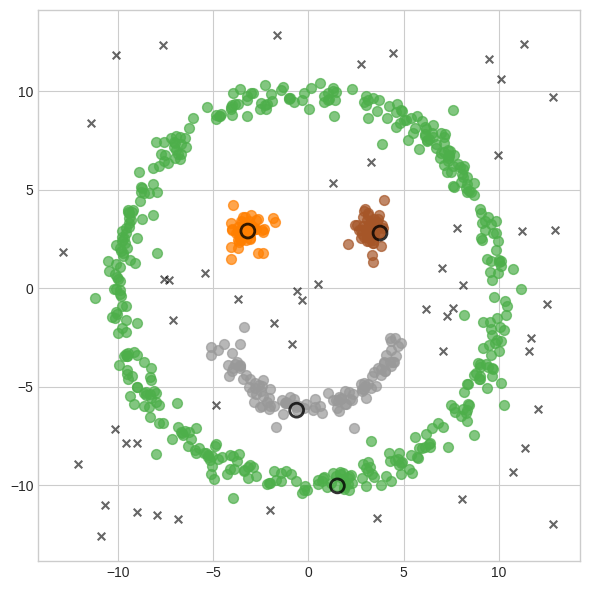

In [39]:
dbscan = DBSCAN(eps=1.3, min_pts=7)
labels = dbscan.fit_predict(X_synthetic)

plt.figure(figsize=(6, 6))
unique_labels = np.unique(labels)
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for k, label in enumerate(unique_labels):
    if label == -1:
        # Ruído
        mask = labels == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c='black', marker='x', s=30, alpha=0.6, label='Ruído')
    else:
        # Clusters
        mask = labels == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1], c=[colors[k]], s=50, alpha=0.7, label=f'Cluster {label}')

# Destacar core points
if len(dbscan.core_samples_) > 0:
    plt.scatter(X_synthetic[dbscan.core_samples_, 0],
                X_synthetic[dbscan.core_samples_, 1],
                s=100, facecolors='none', edgecolors='black',
                linewidth=2, alpha=0.8)

plt.tight_layout()
plt.show()

## Aplicando DBSCAN aos Dados Sintéticos

Agora vamos aplicar nosso algoritmo DBSCAN:

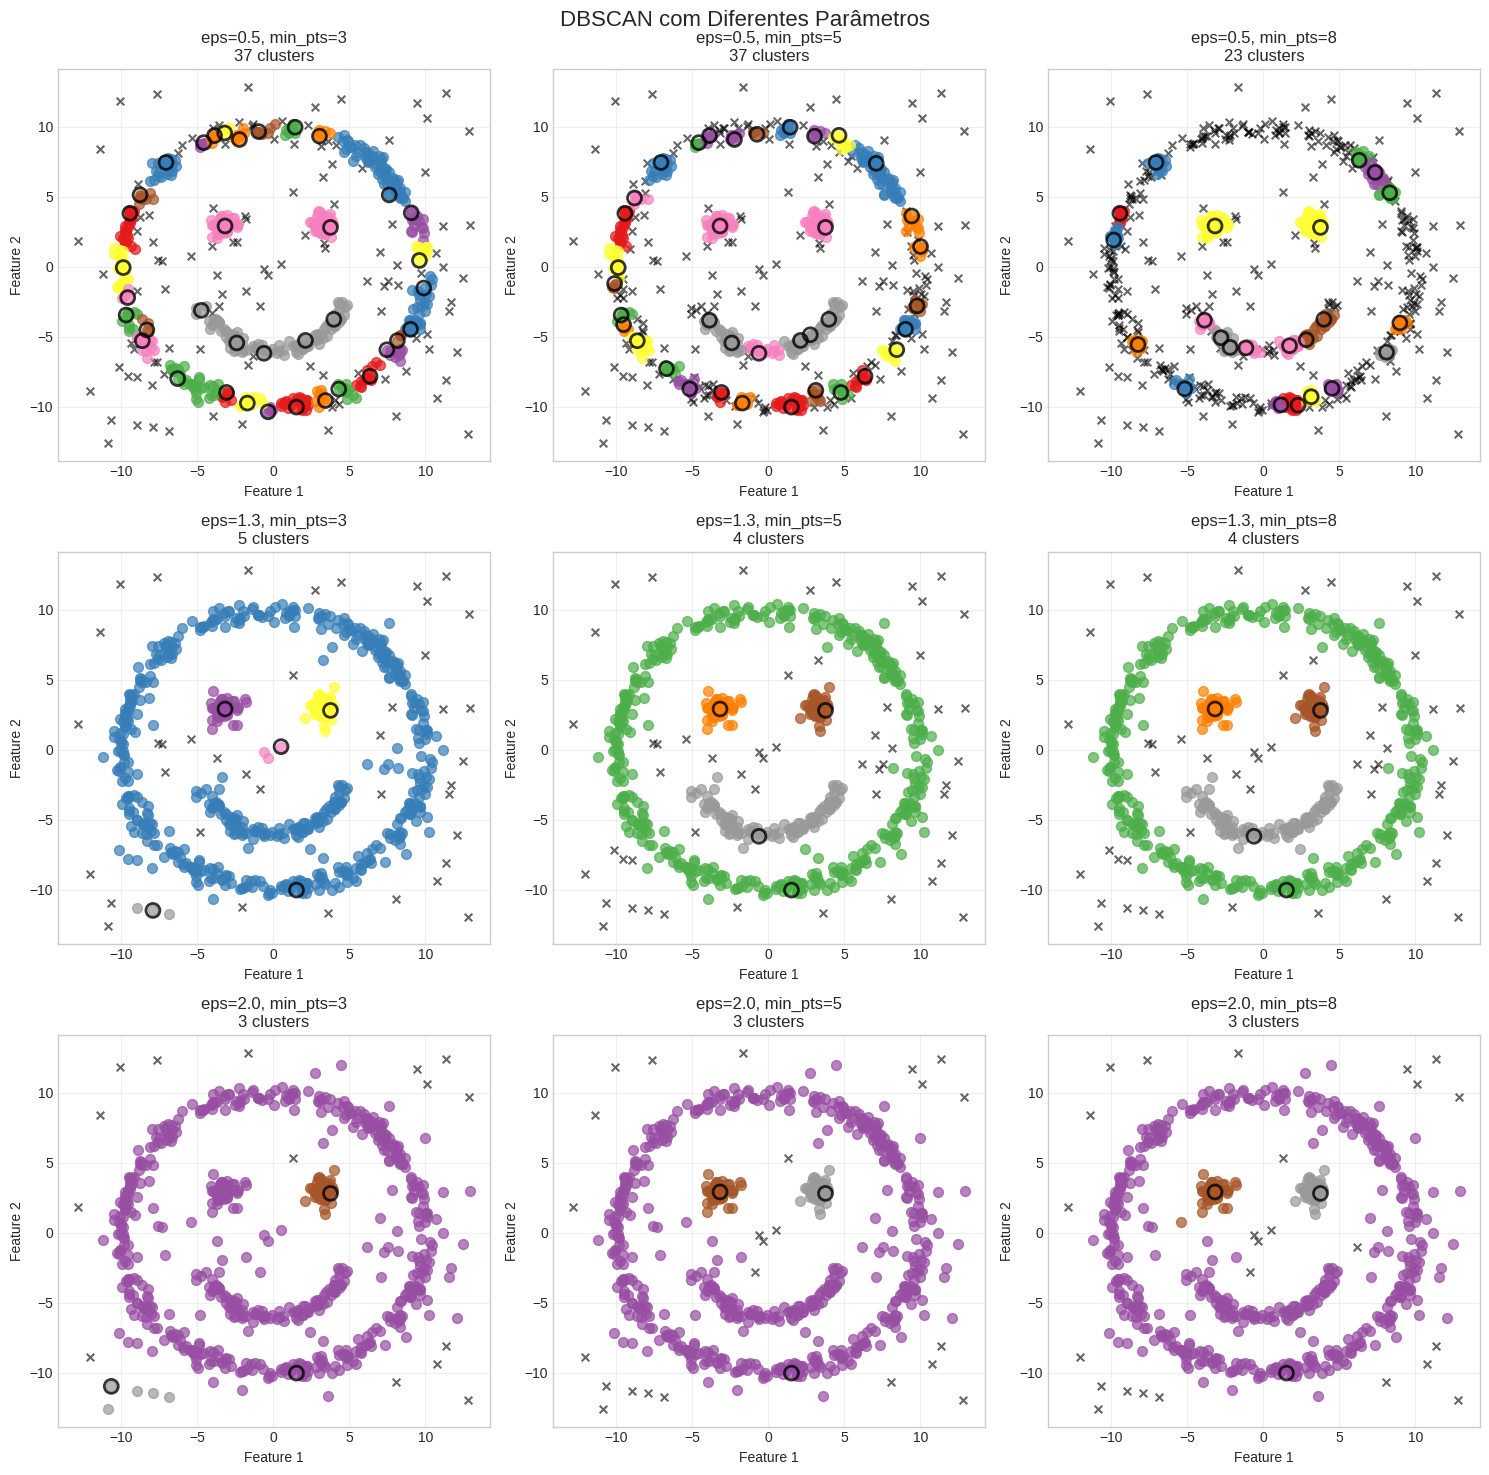

In [40]:
# Testar diferentes valores de eps e min_pts
eps_values = [0.5, 1.3, 2.0]
min_pts_values = [3, 5, 8]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('DBSCAN com Diferentes Parâmetros', fontsize=16)

for i, eps in enumerate(eps_values):
    for j, min_pts in enumerate(min_pts_values):
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_pts=min_pts)
        labels = dbscan.fit_predict(X_synthetic)

        # Visualizar resultados
        ax = axes[i, j]

        unique_labels = np.unique(labels)
        colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

        for k, label in enumerate(unique_labels):
            if label == -1:
                # Ruído
                mask = labels == label
                ax.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1],
                          c='black', marker='x', s=30, alpha=0.6, label='Ruído')
            else:
                # Clusters
                mask = labels == label
                ax.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1],
                          c=[colors[k]], s=50, alpha=0.7, label=f'Cluster {label}')

        # Destacar core points
        if len(dbscan.core_samples_) > 0:
            ax.scatter(X_synthetic[dbscan.core_samples_, 0],
                      X_synthetic[dbscan.core_samples_, 1],
                      s=100, facecolors='none', edgecolors='black',
                      linewidth=2, alpha=0.8)

        ax.set_title(f'eps={eps}, min_pts={min_pts}\n{dbscan.n_clusters_} clusters')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Análise com Parâmetros Ótimos

Vamos escolher os parâmetros que melhor capturam a estrutura dos dados:

In [41]:
# Parâmetros que parecem funcionar melhor
best_eps = 1.3
best_min_pts = 5

# Aplicar DBSCAN com os melhores parâmetros
dbscan_best = DBSCAN(eps=best_eps, min_pts=best_min_pts)
labels_best = dbscan_best.fit_predict(X_synthetic)

# Análise detalhada
unique_labels = np.unique(labels_best)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = np.sum(labels_best == -1)
n_core_samples = len(dbscan_best.core_samples_)

print(f"Resultados do DBSCAN (eps={best_eps}, min_pts={best_min_pts}):")
print(f"- Número de clusters encontrados: {n_clusters}")
print(f"- Número de pontos de ruído: {n_noise}")
print(f"- Número de core samples: {n_core_samples}")
print(f"- Labels únicos: {unique_labels}")

Resultados do DBSCAN (eps=1.3, min_pts=5):
- Número de clusters encontrados: 4
- Número de pontos de ruído: 53
- Número de core samples: 4
- Labels únicos: [-1  0  1  2  3]


In [42]:
# Classificar pontos por tipo
core_mask = np.zeros(len(X_synthetic), dtype=bool)
if len(dbscan_best.core_samples_) > 0:
    core_mask[dbscan_best.core_samples_] = True

border_mask = (labels_best != -1) & (~core_mask)
noise_mask = labels_best == -1

print(f"Classificação dos pontos:")
print(f"- Core points: {np.sum(core_mask)}")
print(f"- Border points: {np.sum(border_mask)}")
print(f"- Noise points: {np.sum(noise_mask)}")

Classificação dos pontos:
- Core points: 4
- Border points: 643
- Noise points: 53


/tmp/ipython-input-1499407514.py:48: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



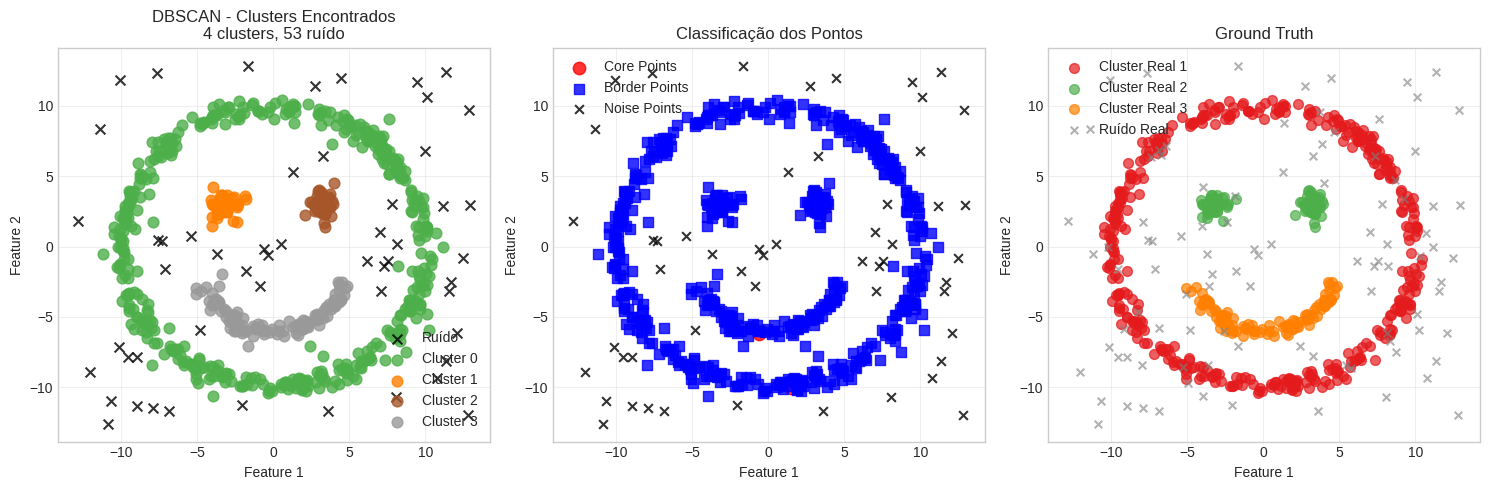

In [43]:
# Visualização detalhada dos tipos de pontos
plt.figure(figsize=(15, 5))

# Subplot 1: Clusters encontrados
plt.subplot(1, 3, 1)
colors = plt.cm.Set1(np.linspace(0, 1, max(len(unique_labels), 3)))

for i, label in enumerate(unique_labels):
    if label == -1:
        mask = labels_best == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1],
                   c='black', marker='x', s=50, alpha=0.8, label='Ruído')
    else:
        mask = labels_best == label
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1],
                   c=[colors[i]], s=60, alpha=0.8, label=f'Cluster {label}')

plt.title(f'DBSCAN - Clusters Encontrados\n{n_clusters} clusters, {n_noise} ruído')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Tipos de pontos
plt.subplot(1, 3, 2)
plt.scatter(X_synthetic[core_mask, 0], X_synthetic[core_mask, 1],
           c='red', s=80, alpha=0.8, label='Core Points', marker='o')
plt.scatter(X_synthetic[border_mask, 0], X_synthetic[border_mask, 1],
           c='blue', s=60, alpha=0.8, label='Border Points', marker='s')
plt.scatter(X_synthetic[noise_mask, 0], X_synthetic[noise_mask, 1],
           c='black', s=40, alpha=0.8, label='Noise Points', marker='x')

plt.title('Classificação dos Pontos')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Comparação com ground truth
plt.subplot(1, 3, 3)
for i in range(4):
    if i == 3:  # ruído
        mask = true_labels == -1
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1],
                   c='gray', alpha=0.6, s=30, marker='x', label='Ruído Real')
    else:
        mask = true_labels == i
        plt.scatter(X_synthetic[mask, 0], X_synthetic[mask, 1],
                   c=colors[i], alpha=0.7, s=50, label=f'Cluster Real {i+1}')

plt.title('Ground Truth')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Estimativa do Parâmetro $\varepsilon$ usando K-Distance

Uma das maiores dificuldades do DBSCAN é escolher o valor apropriado para o parâmetro $\varepsilon$ (eps). O método **K-Distance** é uma heurística eficaz para estimar este parâmetro.

O método K-Distance consiste em:

1. **Calcular a k-ésima distância mais próxima** para cada ponto no dataset
2. **Ordenar essas distâncias** em ordem decrescente
3. **Identificar o "cotovelo"** no gráfico resultante

A intuição é que pontos dentro de clusters densos terão k-ésimas distâncias pequenas, enquanto pontos de ruído ou em bordas de clusters terão distâncias maiores.

### Algoritmo K-Distance:

Para um dataset $D$ e parâmetro $k = \text{minPts} - 1$:

1. Para cada ponto $p_i \in D$:
   - Calcule $d_k(p_i)$ = distância ao k-ésimo vizinho mais próximo
2. Ordene os valores $d_k(p_i)$
3. Plote o gráfico K-Distance
4. Escolha $\varepsilon$ no ponto onde a curva tem maior curvatura (cotovelo)

In [44]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform

def plot_k_distance(X, min_pts, title="K-Distance Plot", metric='euclidean'):
    """Plota o gráfico K-Distance."""
    k = int(min_pts - 1)
    n_points = len(X)

    if metric == 'radial':
        # Calculate radial distances manually
        distances_to_origin = np.linalg.norm(X, axis=1)
        # Calculate the absolute difference of distances to origin for all pairs
        radial_distance_matrix = np.abs(distances_to_origin[:, np.newaxis] - distances_to_origin)

        # Find the k-th nearest neighbor distance from the radial distance matrix
        # For each point, sort its radial distances to all other points and pick the k-th one
        kth_distances = np.sort(radial_distance_matrix, axis=1)[:, k]

    elif metric == 'euclidean':
        nn = NearestNeighbors(n_neighbors=k+1, metric=metric)
        nn.fit(X)
        distances, _ = nn.kneighbors(X)
        kth_distances = distances[:, k]
    elif metric == 'dtw':
        from dtaidistance import dtw # Import here to avoid dependency if not used
        print("Calculating DTW distances for K-Distance plot...")
        # Calculate pairwise DTW distances and find the k-th nearest neighbor distance
        kth_distances = np.zeros(n_points)
        for i in range(n_points):
            # Calculate distance from point i to all other points
            distances_from_i = [dtw.distance_fast(X[i], X[j]) for j in range(n_points)]
            # Sort distances and pick the k-th one (k+1 because the first distance is to itself, which is 0)
            kth_distances[i] = np.sort(distances_from_i)[k+1] # k+1 because the list includes distance to itself (0)
        print("DTW K-Distance calculation complete.")
    else:
        raise ValueError(f"Métrica não suportada para K-Distance Plot: {metric}")

    k_distances_sorted = np.sort(kth_distances)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(k_distances_sorted)), k_distances_sorted, linewidth=2, label=f'{k}-distance ({metric})')
    plt.xlabel("Pontos ordenados por distância")
    plt.ylabel(f"{k}-distance")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

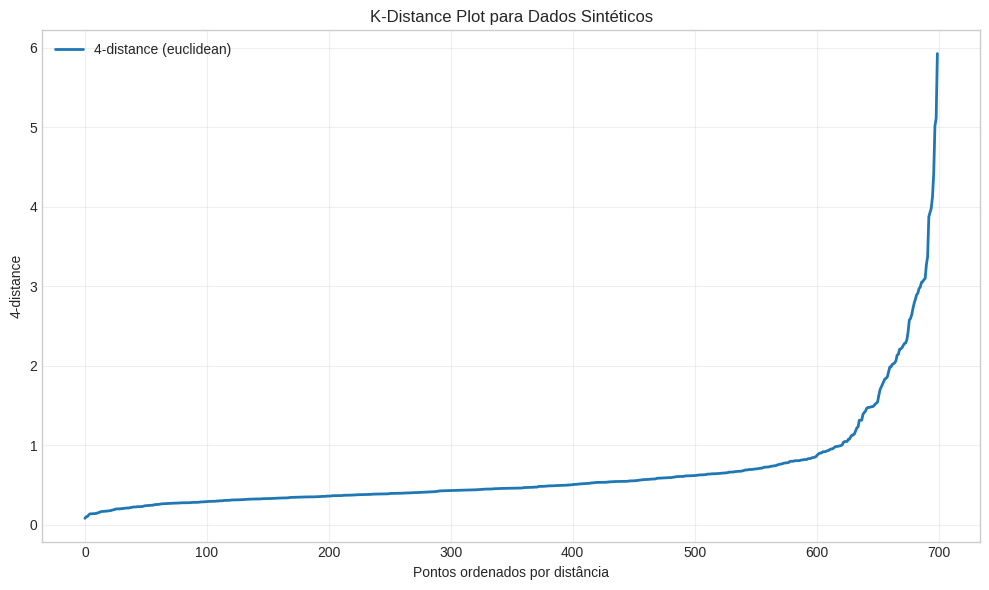

In [45]:
plot_k_distance(X_synthetic, min_pts=5, title="K-Distance Plot para Dados Sintéticos")

## Vantagens e Desvantagens do DBSCAN

### Vantagens:

1. **Não requer especificar o número de clusters antecipadamente**
2. **Pode encontrar clusters de forma arbitrária** (não apenas esféricos)
3. **Identifica automaticamente outliers/ruído**
4. **Robusto a outliers** (não afetam a formação dos clusters)
5. **Determinístico** (sempre produz os mesmos resultados)

### Desvantagens:

1. **Sensível aos parâmetros** eps e min_pts
2. **Dificuldade com clusters de densidades diferentes**
3. **Problemas em alta dimensionalidade** ("curse of dimensionality")
4. **Complexidade computacional** O(n²) no pior caso
5. **Requer escolha cuidadosa da métrica de distância**

## Exercícios

### Exercício 1: Ajuste de Parâmetros no DBSCAN em 3D

Com os dados das **três esferas concêntricas**, realize:

1. Plotar o K-Distance para diferentes valores de `min_pts` e sugerir um intervalo adequado para `eps`.
2. Selecionar os melhores parâmetros de `min_pts` e `eps`.
3. Visualizar em 3D os clusters encontrados (cores diferentes) e comentar a escolha de `eps` e `min_samples`.

In [46]:
from sklearn.preprocessing import StandardScaler

def generate_concentric_spheres(radii=[3, 15], n_samples_per_sphere=1000, noise=0.2, random_state=42):
    """
    Gera pontos em 3 esferas concêntricas no espaço 3D.
    - radii: lista com os raios das esferas
    - n_samples_per_sphere: pontos em cada esfera
    - noise: variação radial para "espessura" da casca
    """
    rng = np.random.default_rng(random_state)
    X, y = [], []

    for i, r in enumerate(radii):
        # amostrar ângulos uniformemente
        phi = rng.uniform(0, 2*np.pi, n_samples_per_sphere)       # ângulo azimutal
        costheta = rng.uniform(-1, 1, n_samples_per_sphere)       # cos(theta)
        theta = np.arccos(costheta)                               # ângulo polar

        # raio com ruído
        rr = r + noise * rng.standard_normal(n_samples_per_sphere)

        # coordenadas cartesianas
        x = rr * np.sin(theta) * np.cos(phi)
        y_ = rr * np.sin(theta) * np.sin(phi)
        z = rr * np.cos(theta)

        X.append(np.vstack((x, y_, z)).T)
        y.append(np.full(n_samples_per_sphere, i))

    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

X_spheres, y_spheres = generate_concentric_spheres(radii=[3, 8, 12], n_samples_per_sphere=200, noise=0.4)

scaler = StandardScaler()
X_spheres = scaler.fit_transform(X_spheres)

In [47]:
import plotly.express as px

fig = px.scatter_3d(
    x=X_spheres[:, 0],
    y=X_spheres[:, 1],
    z=X_spheres[:, 2],
    color_continuous_scale=px.colors.qualitative.Vivid,
)
fig.update_traces(marker=dict(size=3))
fig.show()

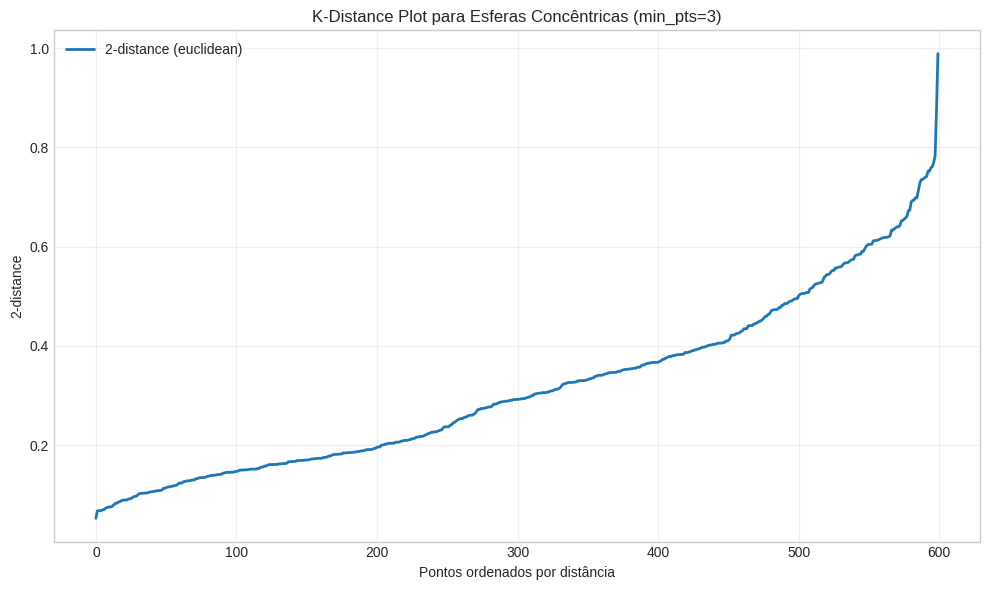

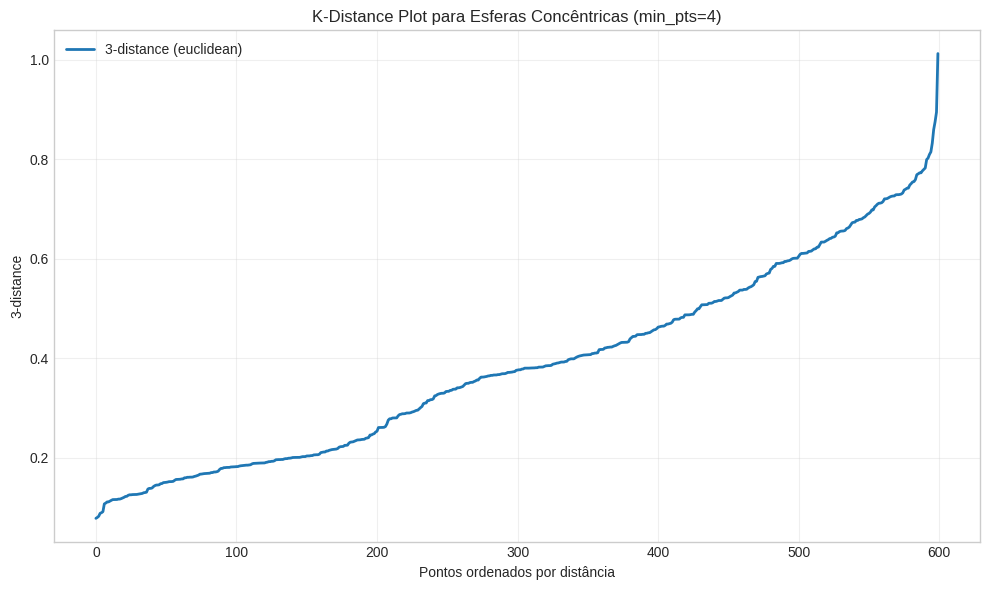

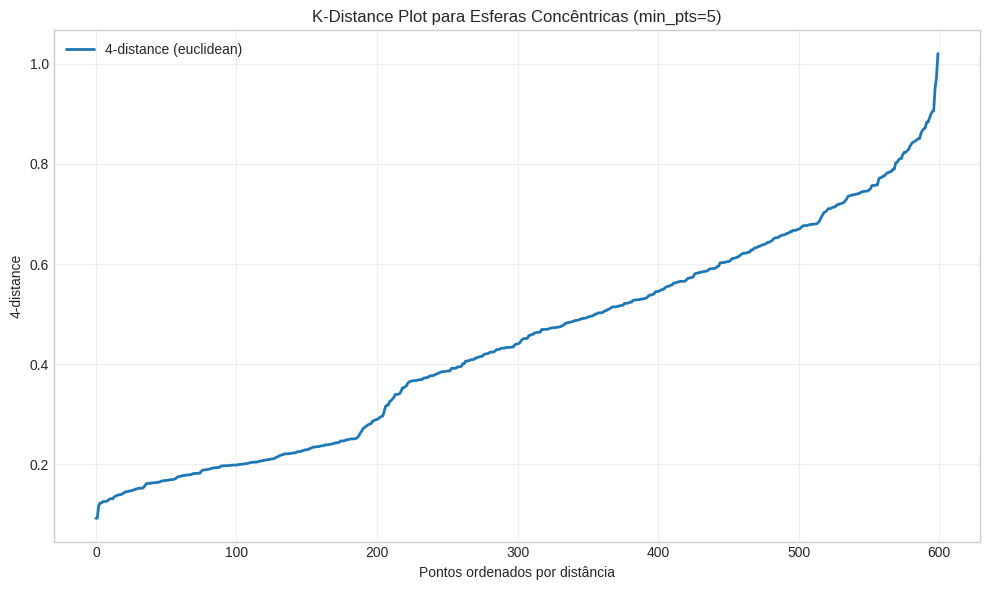

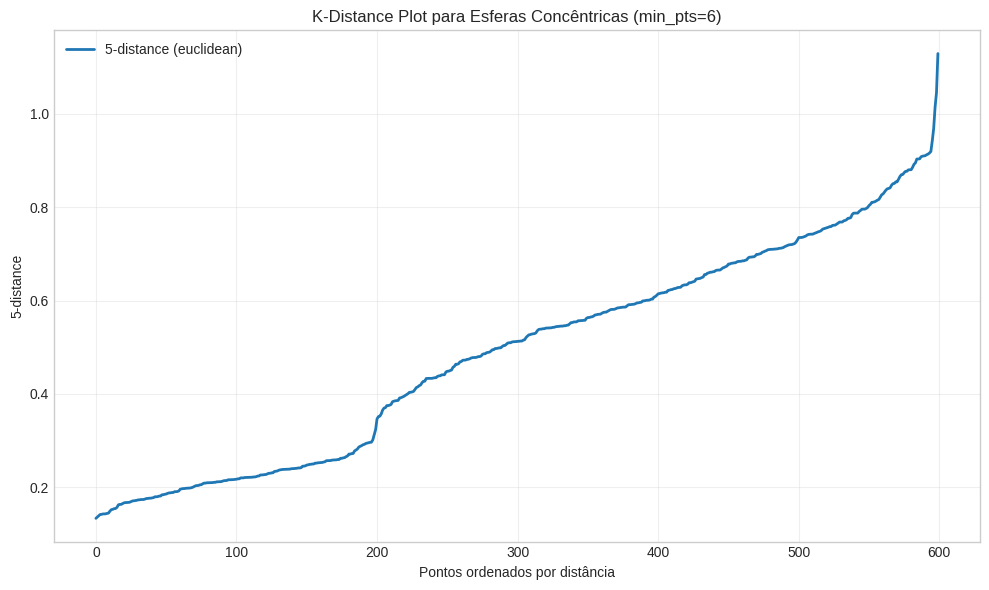

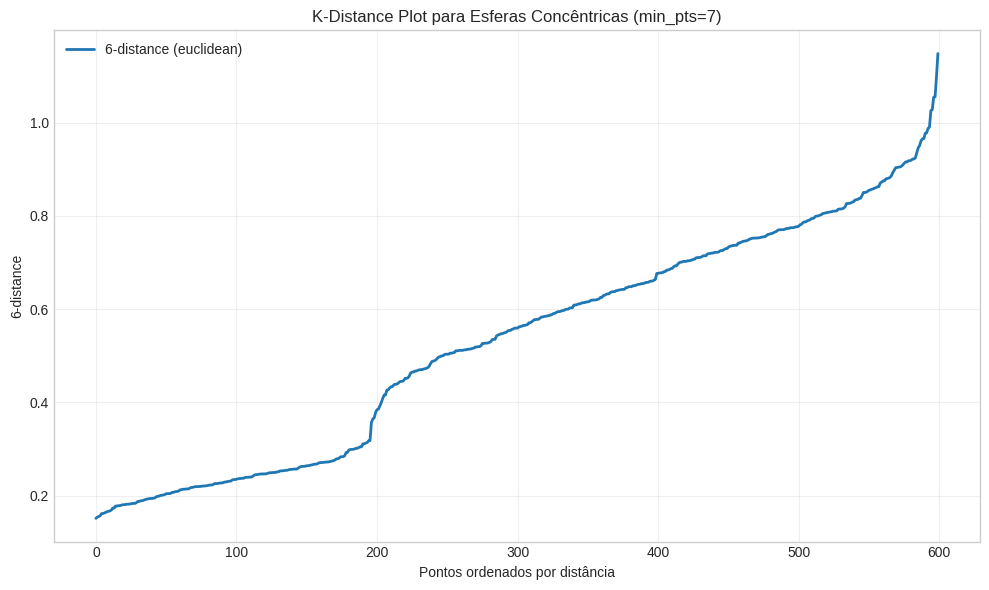

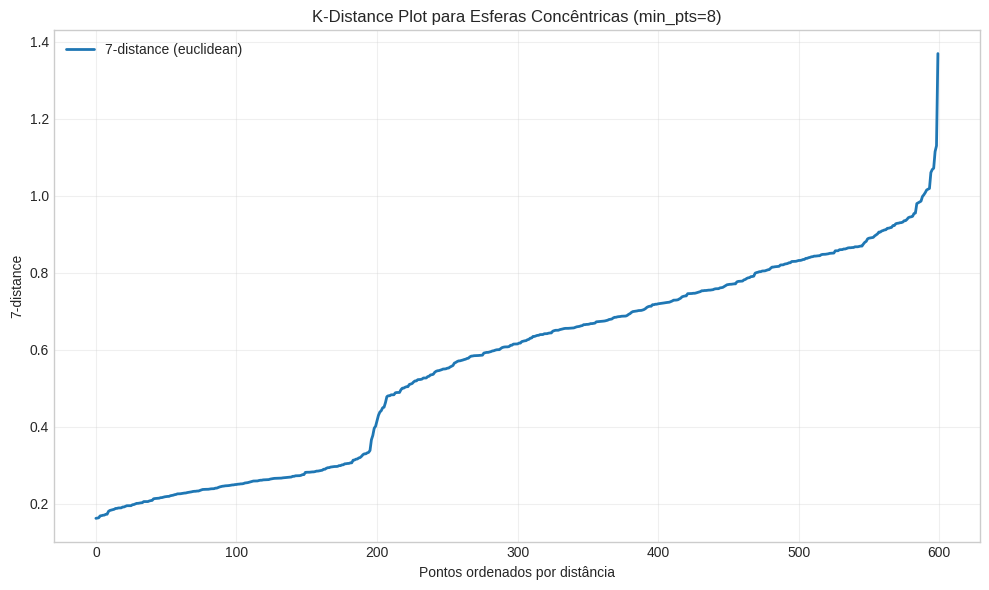

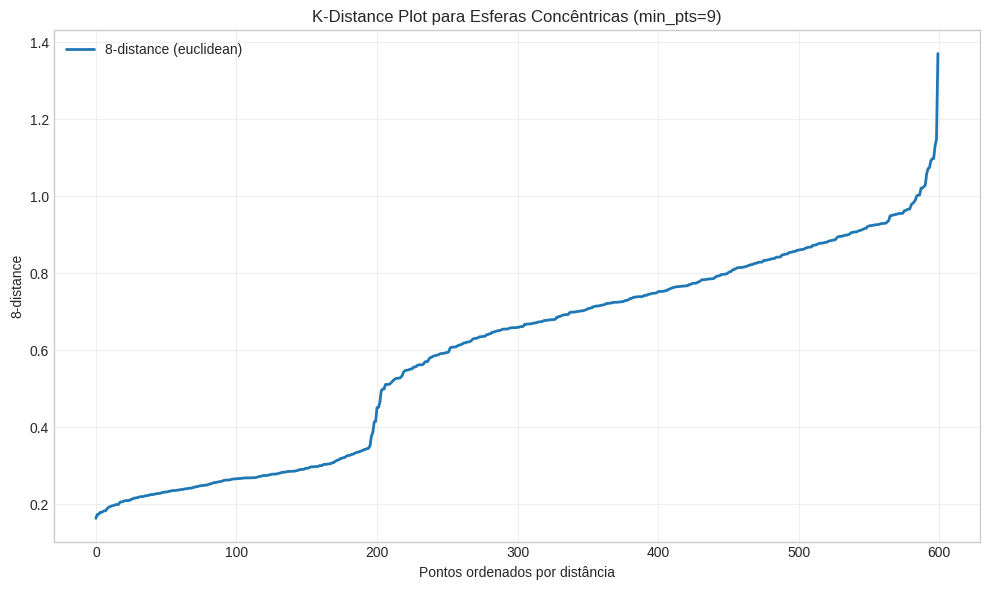

In [48]:
# Avaliando para vários eps e min de pontos
min_pts_values_kdist = range(3, 10)

for min_pts in min_pts_values_kdist:
    plot_k_distance(X_spheres, min_pts=min_pts, title=f"K-Distance Plot para Esferas Concêntricas (min_pts={min_pts})")

In [49]:
# Aplicando DBScan com distância euclidiana

# Parâmetros escolhidos
best_euc_eps = 0.71
best_auc_min_pts = 3

dbscan_euc = DBSCAN(eps=best_euc_eps, min_pts=best_auc_min_pts)
labels_euc = dbscan_euc.fit_predict(X_spheres)

unique_labels_euc = np.unique(labels_euc)
n_clusters_euc = len(unique_labels_euc) - (1 if -1 in unique_labels_euc else 0)
n_noise_euc = np.sum(labels_euc == -1)
n_core_samples_euc = len(dbscan_euc.core_samples_)

print(f"Resultados do DBSCAN: eps={best_euc_eps}, min_pts={best_auc_min_pts}")
print(f"- Número de clusters encontrados: {n_clusters_euc}")
print(f"- Número de pontos de ruído: {n_noise_euc}")
print(f"- Número de core samples: {n_core_samples_euc}")
print(f"- Labels únicos: {unique_labels_euc}")

# Visualização dos clusteres
fig_radial = px.scatter_3d(
    x=X_spheres[:, 0],
    y=X_spheres[:, 1],
    z=X_spheres[:, 2],
    color=labels_euc.astype(str),
    color_continuous_scale=px.colors.qualitative.Vivid,
    title=f'DBSCAN Euclidian (eps={best_euc_eps}, min_pts={best_auc_min_pts})'
)
fig_radial.update_traces(marker=dict(size=3))
fig_radial.show()

# Foi impossível para mim encontrar parâmetros satifatórios

Resultados do DBSCAN: eps=0.71, min_pts=3
- Número de clusters encontrados: 1
- Número de pontos de ruído: 5
- Número de core samples: 1
- Labels únicos: [-1  0]


### Exercício 2: DBSCAN com distância radial

Usando os dados das **3 esferas concêntricas** do exercício anterior:

1. Implemente a **distância radial** e use-a no DBSCAN. A **distância radial** entre dois pontos \(x_i\) e \(x_j\) é a diferença absoluta entre suas distâncias à origem: $d_{\text{radial}}(x_i, x_j) = \big|\;\|x_i\|_2 - \|x_j\|_2\;\big|$
2. Plote o **K-Distance radial** para sugerir `eps`.  
3. Teste combinações de `eps` e `min_samples`.  
4. Visualize em 3D os clusters obtidos e compare com o resultado usando distância euclidiana.  
5. Comente brevemente qual configuração foi melhor e por quê a métrica radial ajuda nesse dataset.

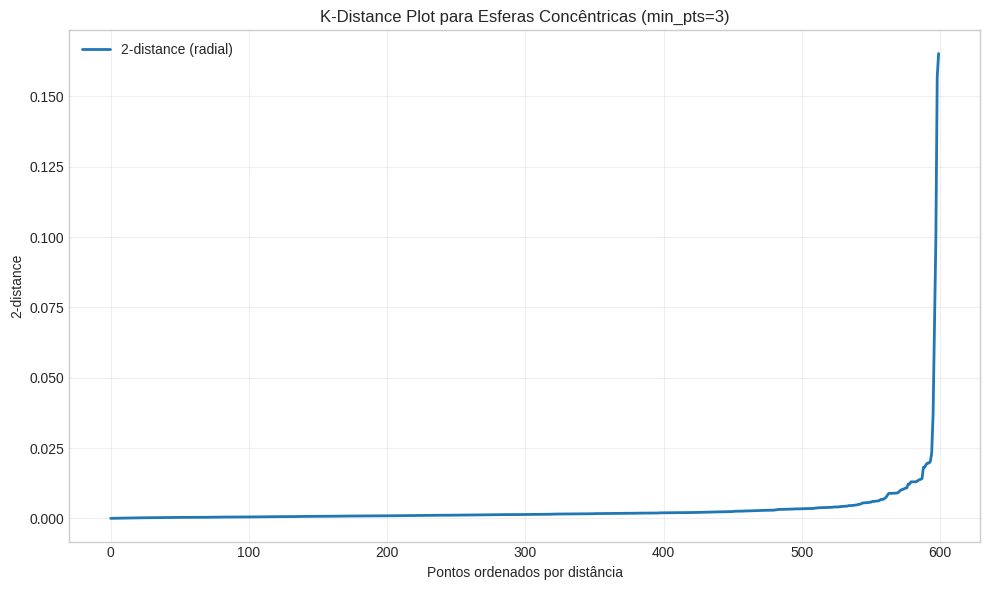

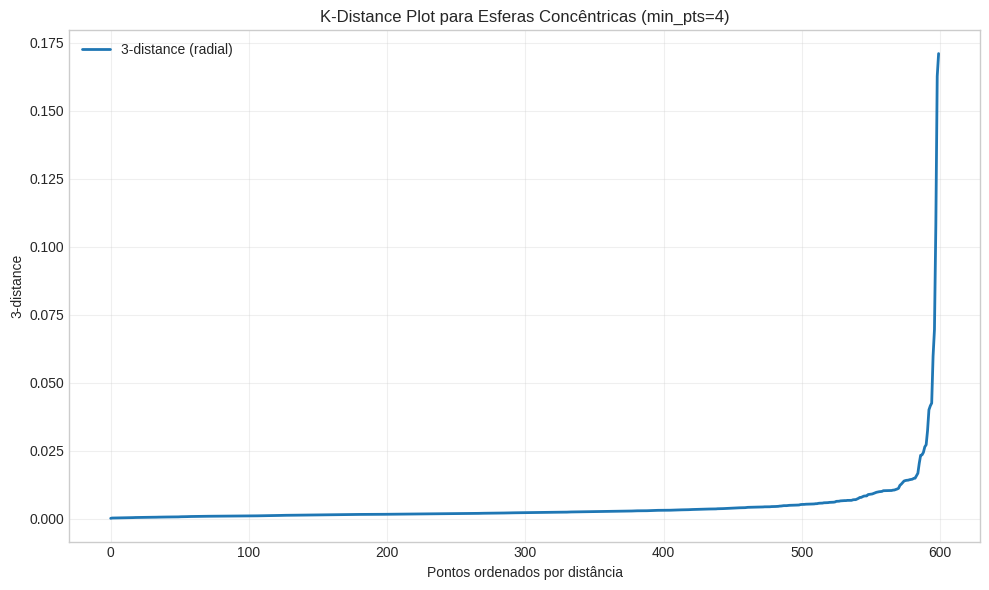

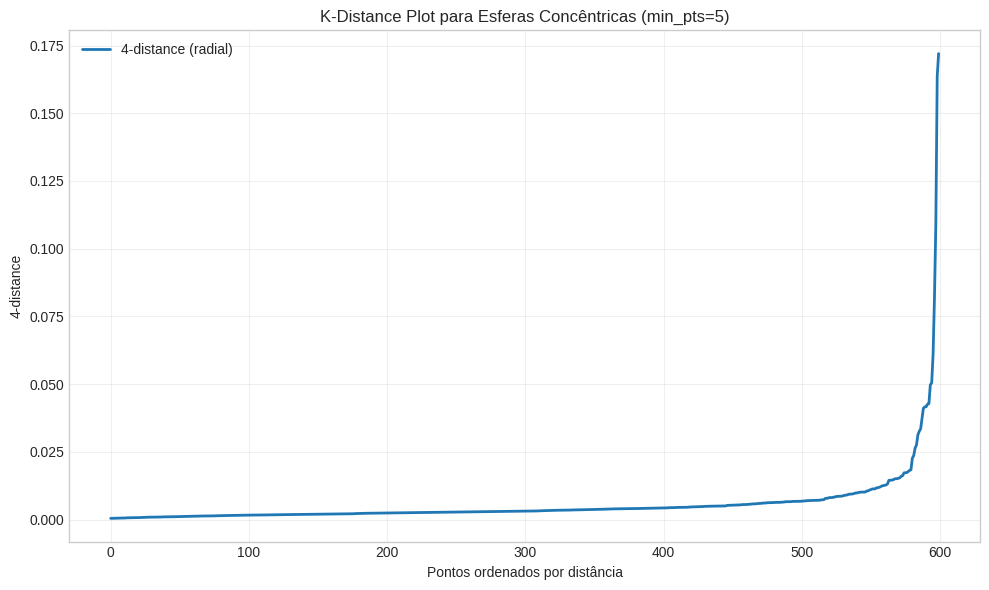

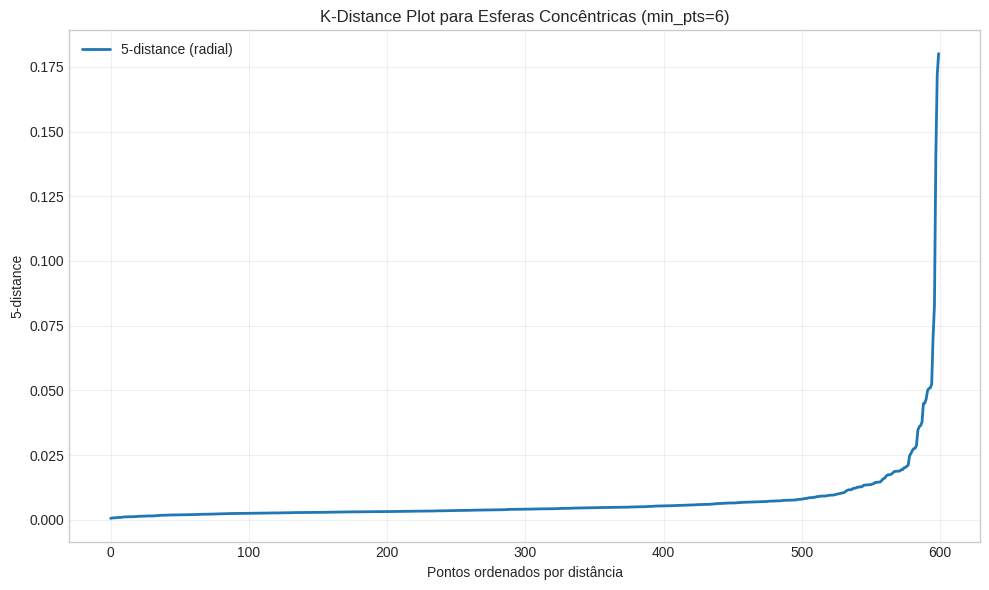

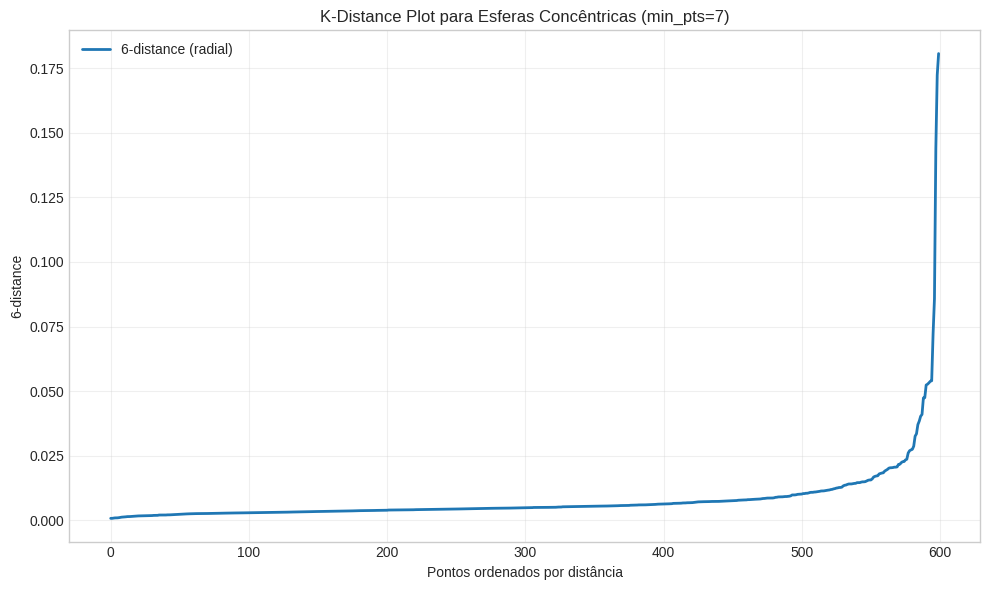

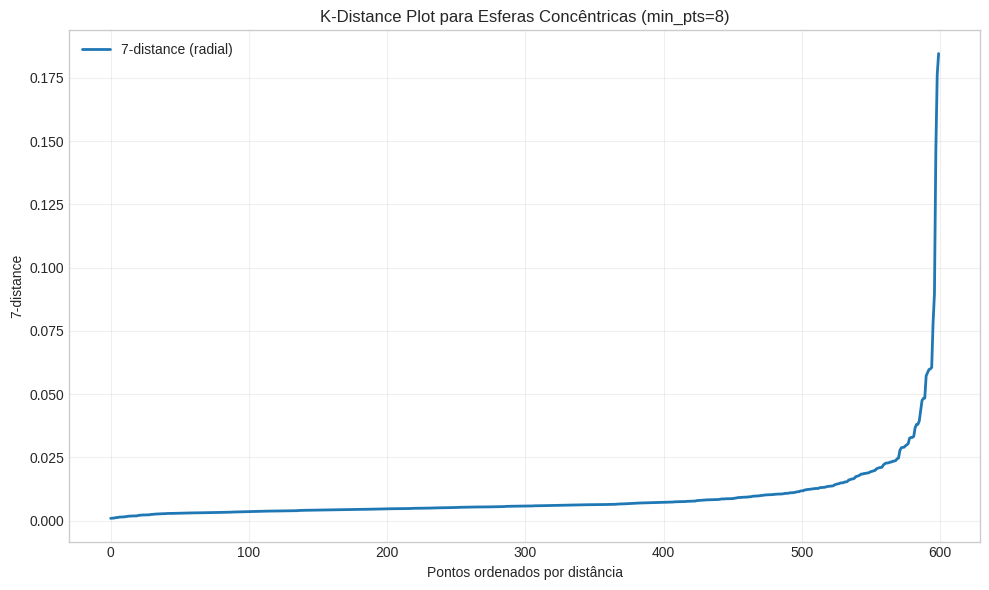

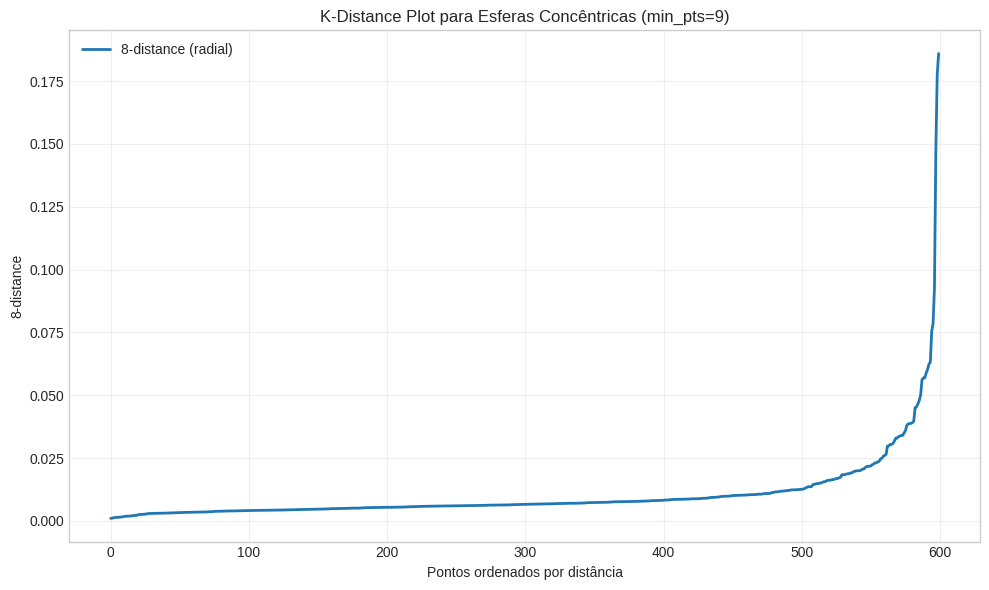

In [50]:
# Avaliando para vários eps e min de pontos
min_pts_values_kdist = range(3, 10)

for min_pts in min_pts_values_kdist:
    plot_k_distance(X_spheres, min_pts=min_pts, title=f"K-Distance Plot para Esferas Concêntricas (min_pts={min_pts})", metric='radial')

In [51]:
# Aplicando DBScan com distância radial

# Parâmetros escolhidos
best_radial_eps = 0.09
best_radial_min_pts = 4

dbscan_radial = DBSCAN(eps=best_radial_eps, min_pts=best_radial_min_pts, metric='radial')
labels_radial = dbscan_radial.fit_predict(X_spheres)

unique_labels_radial = np.unique(labels_radial)
n_clusters_radial = len(unique_labels_radial) - (1 if -1 in unique_labels_radial else 0)
n_noise_radial = np.sum(labels_radial == -1)
n_core_samples_radial = len(dbscan_radial.core_samples_)

print(f"Resultados do DBSCAN: eps={best_radial_eps}, min_pts={best_radial_min_pts}")
print(f"- Número de clusters encontrados: {n_clusters_radial}")
print(f"- Número de pontos de ruído: {n_noise_radial}")
print(f"- Número de core samples: {n_core_samples_radial}")
print(f"- Labels únicos: {unique_labels_radial}")

# Visualização dos clusteres
fig_radial = px.scatter_3d(
    x=X_spheres[:, 0],
    y=X_spheres[:, 1],
    z=X_spheres[:, 2],
    color=labels_radial.astype(str),
    color_continuous_scale=px.colors.qualitative.Vivid,
    title=f'DBSCAN Radial (eps={best_radial_eps}, min_pts={best_radial_min_pts})'
)
fig_radial.update_traces(marker=dict(size=3))
fig_radial.show()

# Com os parâmetros escolhidos obtivemos um número baixo de ruído e uma boa definição dos clusters.

Resultados do DBSCAN: eps=0.09, min_pts=4
- Número de clusters encontrados: 3
- Número de pontos de ruído: 3
- Número de core samples: 3
- Labels únicos: [-1  0  1  2]


### Exercício 3: Detecção de Anomalias com DBSCAN e DTW

O **DTW (Dynamic Time Warping)** mede a similaridade entre séries temporais mesmo quando estão defasadas ou com velocidades diferentes, alinhando-as de forma elástica. Isso permite detectar padrões semelhantes sem que a defasagem atrapalhe.

Pode ser calculado por:
```python
from dtaidistance import dtw

n = len(X)              # número de séries
D = np.zeros((n, n))    # matriz de distâncias

for i in range(n):
    for j in range(i+1, n):
        dist = dtw.distance_fast(X[i], X[j])  # distância DTW
        D[i, j] = D[j, i] = dist              # matriz simétrica
````

**Tarefas:**
1. Use o dataset de senóides com variação e **anomalias simuladas**.  
2. Adicione a métrica DTW no DBSCAN.
3. Experimente diferentes valores de `eps` e `min_samples` até que o modelo consiga separar bem séries normais das anômalas.  
4. Plote todas as séries, usando uma cor para as normais e outra para as anomalias detectadas (`label = -1`).  

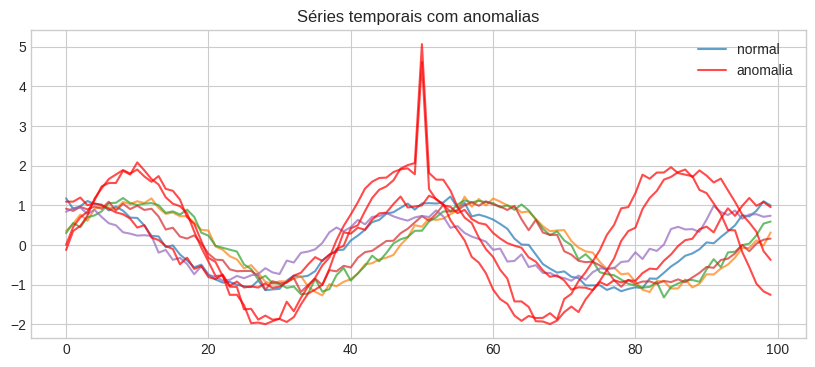

In [52]:
def generate_time_series_dataset(n_series=50, length=100, noise=0.1, n_outliers=2, random_state=42):
    rng = np.random.default_rng(random_state)
    X, y = [], []
    t = np.linspace(0, 4*np.pi, length)

    # séries normais: senóide com amplitude e frequência ligeiramente diferentes
    for _ in range(n_series):
        amp = rng.uniform(0.8, 1.2)         # amplitude
        freq = rng.uniform(0.9, 1.1)        # frequência
        phase = rng.uniform(0, 0.5*np.pi)   # pequena defasagem
        series = amp * np.sin(freq * t + phase) + noise * rng.normal(size=length)
        X.append(series)
        y.append(0)  # normal

    # outliers: picos ou deslocamentos fortes
    for _ in range(n_outliers):
        amp = rng.uniform(1.5, 2.0)         # amplitude anômala
        freq = rng.uniform(1.2, 1.5)        # frequência anômala
        series = amp * np.sin(freq * t) + noise * rng.normal(size=length)
        if rng.random() < 0.5:
            series[length//2] += 3  # pico
        else:
            series += rng.normal(2.0, 0.5)  # deslocamento
        X.append(series)
        y.append(-1)  # anomalia

    return np.array(X), np.array(y)

X_series, y_series = generate_time_series_dataset()

plt.figure(figsize=(10,4))
for i in range(5):
    plt.plot(X_series[i], alpha=0.7, label="normal" if i==0 else "")
for i in range(-3,0):
    plt.plot(X_series[i], alpha=0.7, color="red", label="anomalia" if i==-1 else "")
plt.title("Séries temporais com anomalias")
plt.legend()
plt.show()

Calculating DTW distances for K-Distance plot...
DTW K-Distance calculation complete.


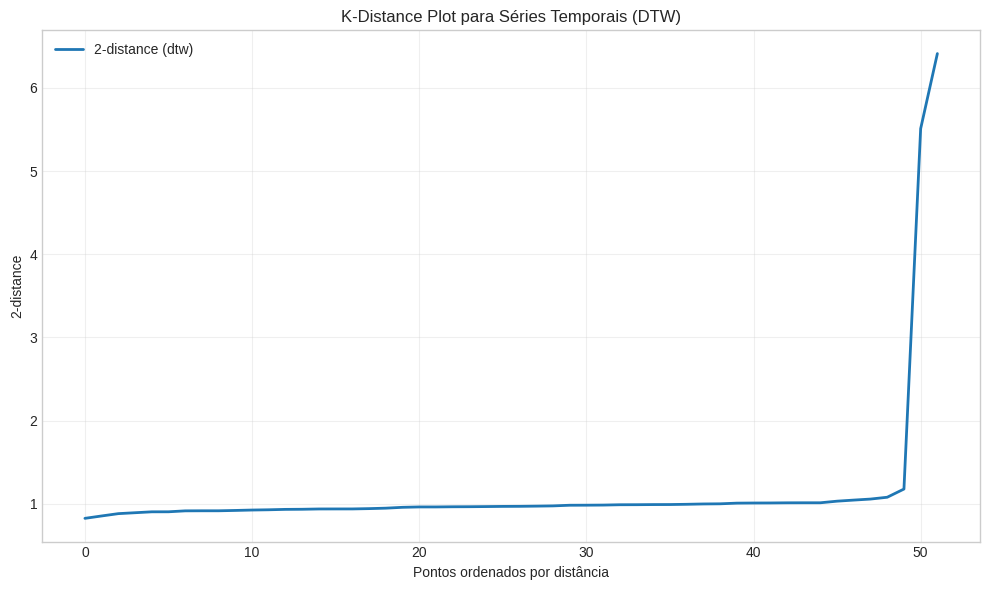

Calculating DTW distances for K-Distance plot...
DTW K-Distance calculation complete.


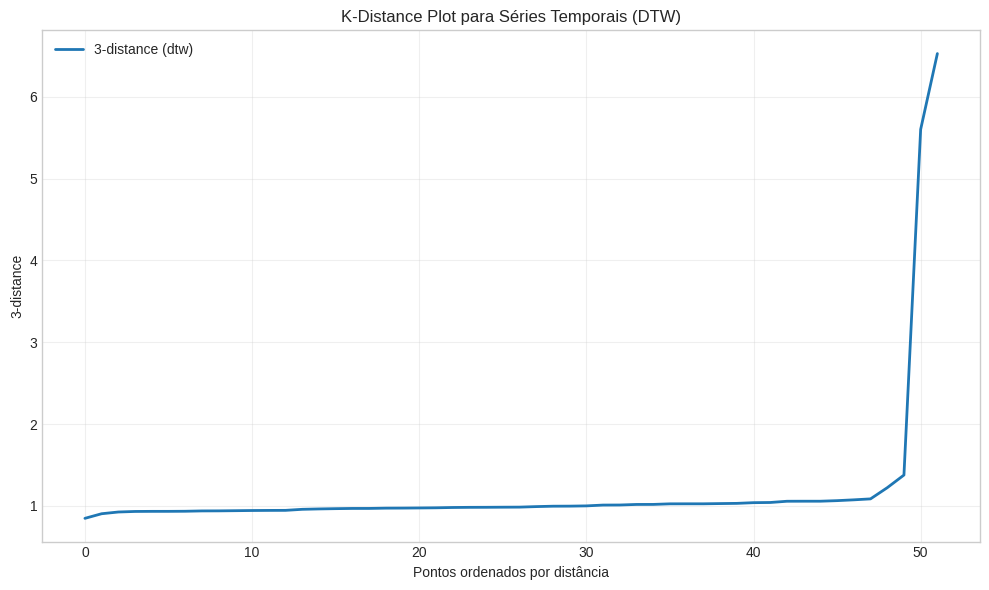

Calculating DTW distances for K-Distance plot...
DTW K-Distance calculation complete.


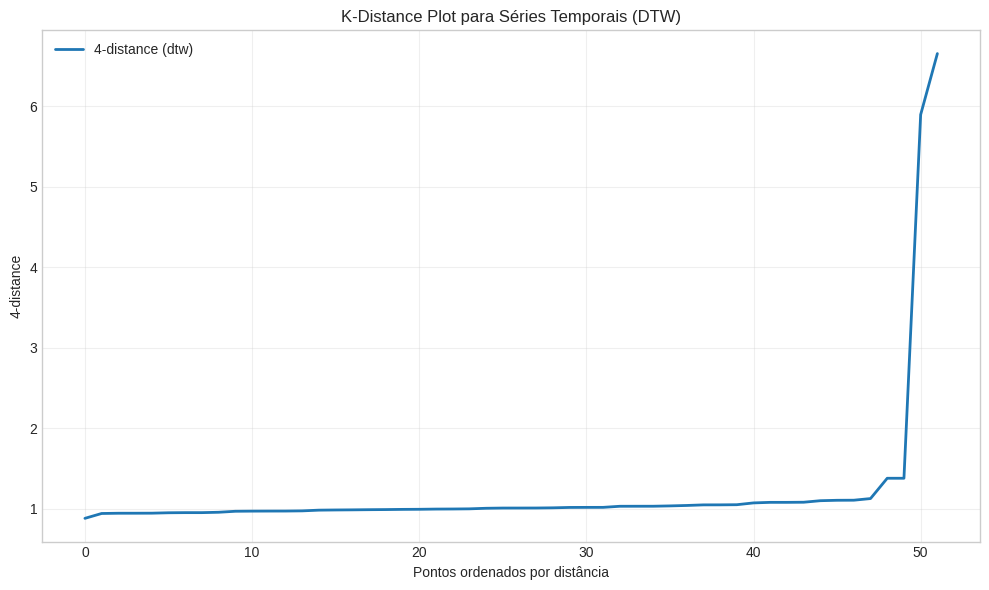

Calculating DTW distances for K-Distance plot...
DTW K-Distance calculation complete.


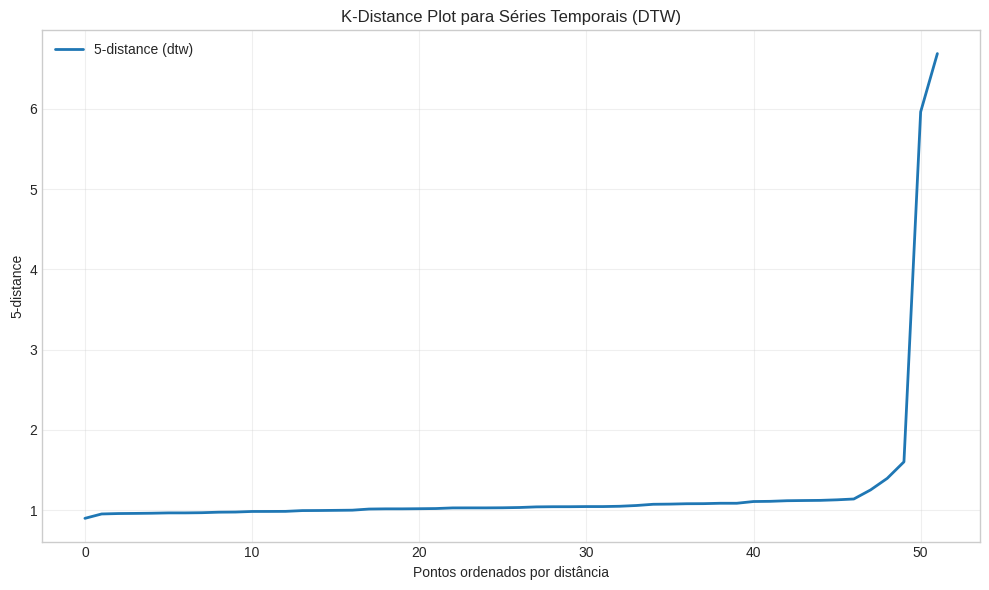

Calculating DTW distances for K-Distance plot...
DTW K-Distance calculation complete.


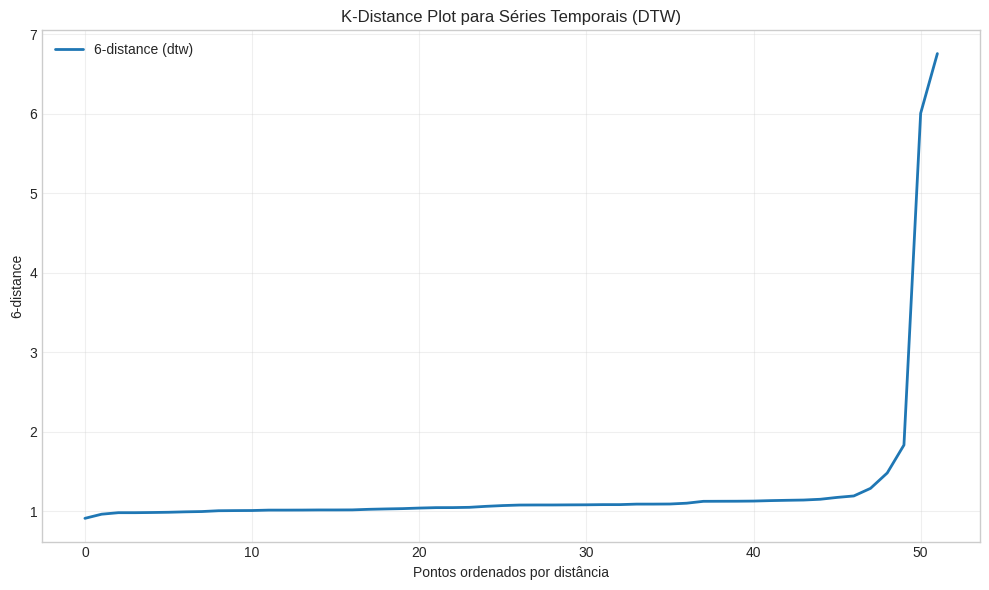

Calculating DTW distances for K-Distance plot...
DTW K-Distance calculation complete.


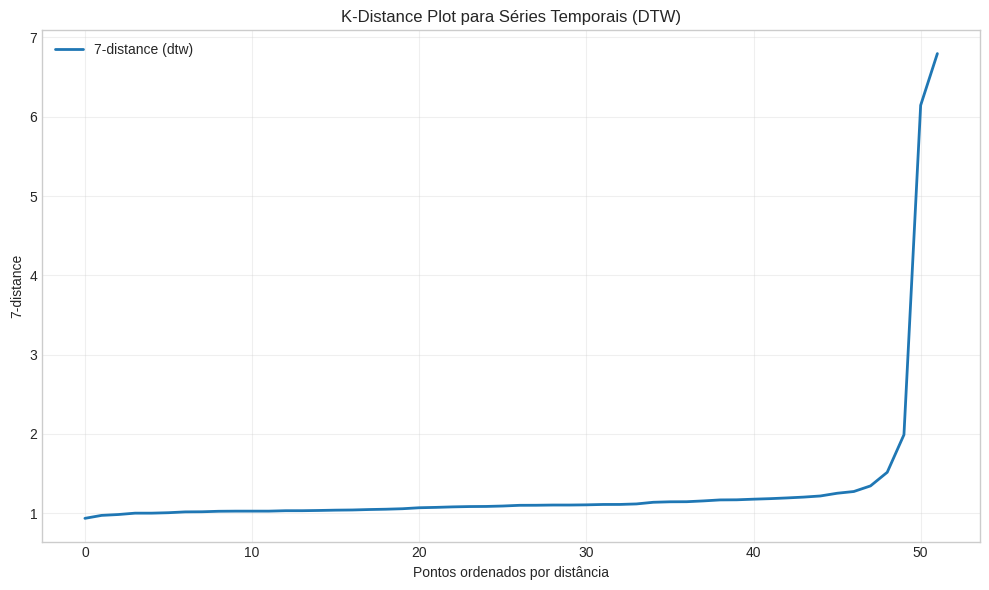

Calculating DTW distances for K-Distance plot...
DTW K-Distance calculation complete.


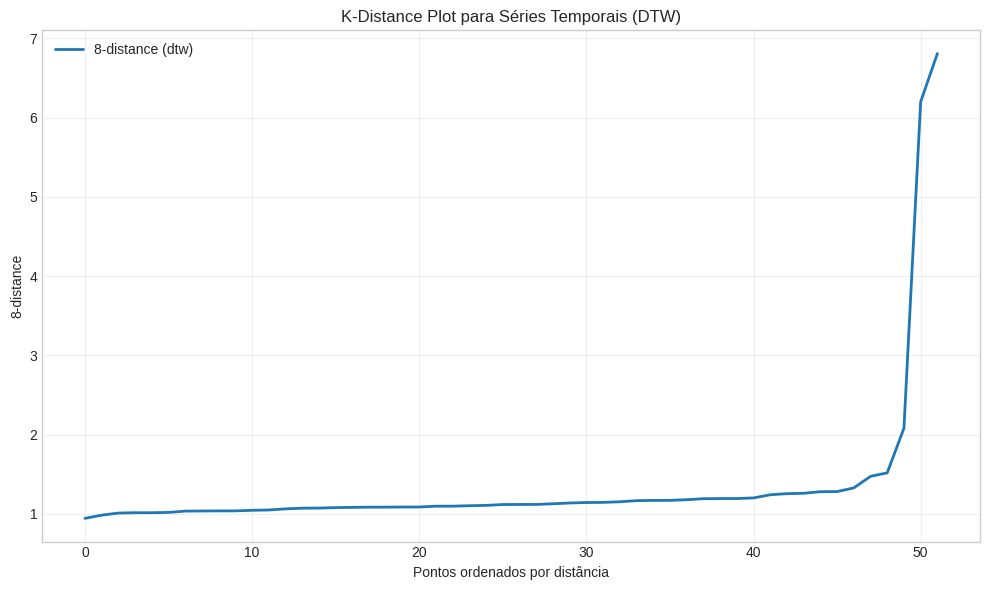

In [53]:
# Estimativa de eps usando K-Distance com métrica DTW

min_pts_values_kdist = range(3, 10)

for min_pts in min_pts_values_kdist:
    plot_k_distance(X_series, min_pts=min_pts, title="K-Distance Plot para Séries Temporais (DTW)", metric='dtw')

Resultados do DBSCAN (métrica DTW, eps=1.4, min_pts=7):
- Número de clusters encontrados: 1
- Número de pontos de ruído (anomalias detectadas): 2
- Labels únicos: [-1  0]


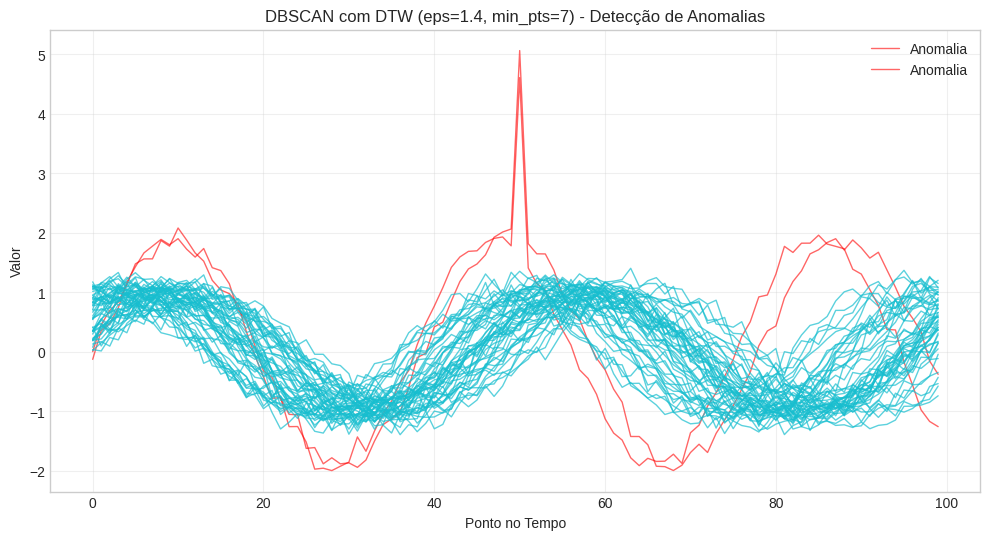

In [54]:
# Aplicar DBSCAN com DTW

# Parâmetros escolhidos
dtw_eps = 1.4
dtw_min_pts = 7

dbscan_dtw = DBSCAN(eps=dtw_eps, min_pts=dtw_min_pts, metric='dtw')
labels_dtw = dbscan_dtw.fit_predict(X_series)

# Análise dos resultados
unique_labels_dtw = np.unique(labels_dtw)
n_clusters_dtw = len(unique_labels_dtw) - (1 if -1 in unique_labels_dtw else 0)
n_noise_dtw = np.sum(labels_dtw == -1)

print(f"Resultados do DBSCAN (métrica DTW, eps={dtw_eps}, min_pts={dtw_min_pts}):")
print(f"- Número de clusters encontrados: {n_clusters_dtw}")
print(f"- Número de pontos de ruído (anomalias detectadas): {n_noise_dtw}")
print(f"- Labels únicos: {unique_labels_dtw}")

plt.figure(figsize=(12, 6))

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels_dtw)))

for i, label in enumerate(unique_labels_dtw):
    mask = labels_dtw == label
    if label == -1:
        plt.plot(X_series[mask].T, color='red', alpha=0.6, linewidth=1, label='Anomalia' if i == 0 else "")
    else:
        plt.plot(X_series[mask].T, color=colors[i], alpha=0.7, linewidth=1, label=f'Cluster {label}' if i == 0 else "")

plt.title(f'DBSCAN com DTW (eps={dtw_eps}, min_pts={dtw_min_pts}) - Detecção de Anomalias')
plt.xlabel('Ponto no Tempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Obtivemos um desempenho muito satisfatório nos agrupamentos.